# Assignment 1

In [1]:
import sys
import nltk
import math
import itertools
import scipy.stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

# Custom string import to get the ASCII lower and uppercase alphabet
import string

## Daten einlesen

In [2]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw.csv', sep=';')

## Hilfsfunktionen

In [3]:
def box_plot(dist, title = None):
    chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
    
    fig1, ax1 = plt.subplots(figsize = (18, 8))
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    ax1.boxplot(dist, labels = chars)
    ax1.set_ylim([0, 0.3])
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
def frequency_plot(mean_en, mean_de):
    chars = [chr(c) for c in range(ord('a'), ord('z')+1)]
    ind = np.arange(len(chars))
    width = 1
    frequency = np.log((np.array(mean_en) / np.array(mean_de)))
    color = ['g' if f > 0 else 'b' for f in frequency]
    
    fig, ax = plt.subplots(figsize = (18, 8))
    rects1 = ax.bar(ind, frequency, width, color = color, edgecolor = 'black')
    ax.set_xticklabels(chars)
    ax.set_xticks(ind + (width * 0.5) - 0.5)
    ax.set_xlabel('Character')
    ax.set_ylim([-2, 2])
    ax.set_ylabel('F')
    ax.set_xlim([-0.5, len(chars) - 0.5])
    ax.text(1, 1.5, 'More frequent in English ', bbox={'facecolor':'green', 'alpha':0.5, 'pad':10})
    ax.text(1, 1.2, 'More frequent in German', bbox={'facecolor':'blue', 'alpha':0.5, 'pad':10})
    ax.text(5.5, 1.35, r'$F = \ln(\frac{mean_e}{mean_d})$', fontsize=25)
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Häufigkeitsverteilungen

In [6]:
def character_distribution(people):
    # Define the dimensions
    dist = np.ones(shape = (len(people), 26))
    mean = np.ones(shape = 26)
    std = np.ones(shape = 26)
    
    # Define an ASCII alphabet string because isalpha() is Unicode based (E.g. 'é' is part of the Swiss alphabet)
    ascii_alphabet = string.ascii_lowercase + string.ascii_uppercase
    
    for index_text, text in enumerate(people):
        # Capture all matching ASCII characters
        matching = [char.lower() for char in text if char in ascii_alphabet]

        # Append the whole alphabet so each character has an occurence of at least one (Tweets)
        for ascii_character in string.ascii_lowercase:
            matching.append(ascii_character)
        
        # Get the frequency
        frequency = nltk.FreqDist(matching)

        # Set the distance per text (Durchschnittlicher relative Häufigkeit pro Buchstabe)
        for index_character, character in enumerate(string.ascii_lowercase):
            dist[index_text, index_character] = frequency.freq(character)

    # Set mean (Relative Standardabweichung pro Buchstabe)
    # Set std (Relative Häufigkeit pro Text und pro Buchstabe)
    for index_character, character in enumerate(string.ascii_lowercase):
        range = dist[:, index_character] # "Splice" the character
        mean[index_character] = range.mean()
        std[index_character] = range.std()
   
    return mean, std, dist

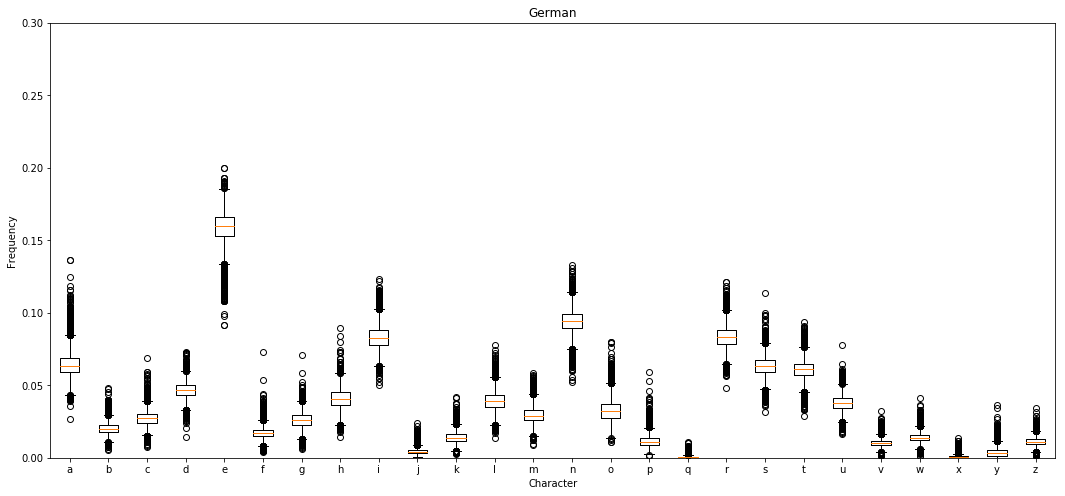

In [7]:
mean_de, std_de, dist_de = character_distribution(people_de['text'])
box_plot(dist_de, 'German')

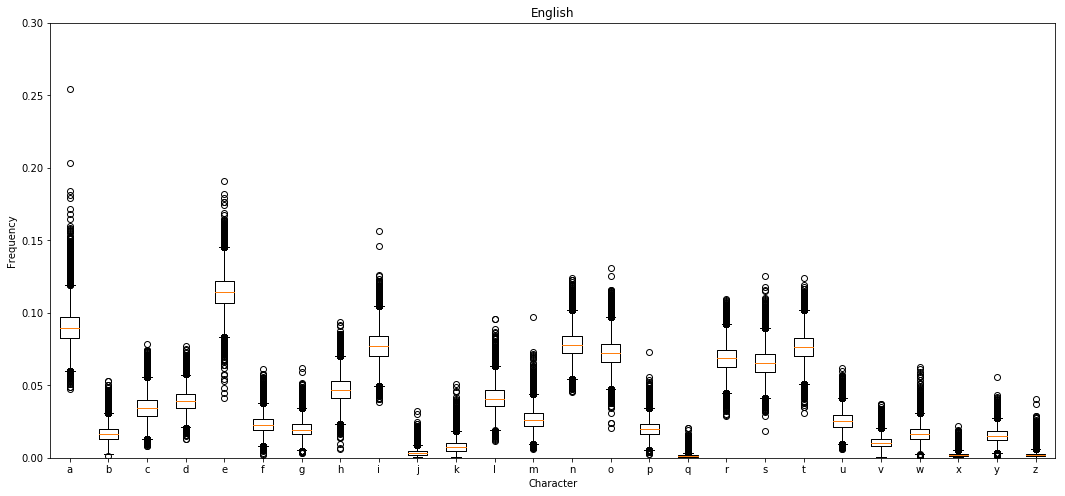

In [8]:
mean_en, std_en, dist_en = character_distribution(people_en['text'])
box_plot(dist_en, 'English')

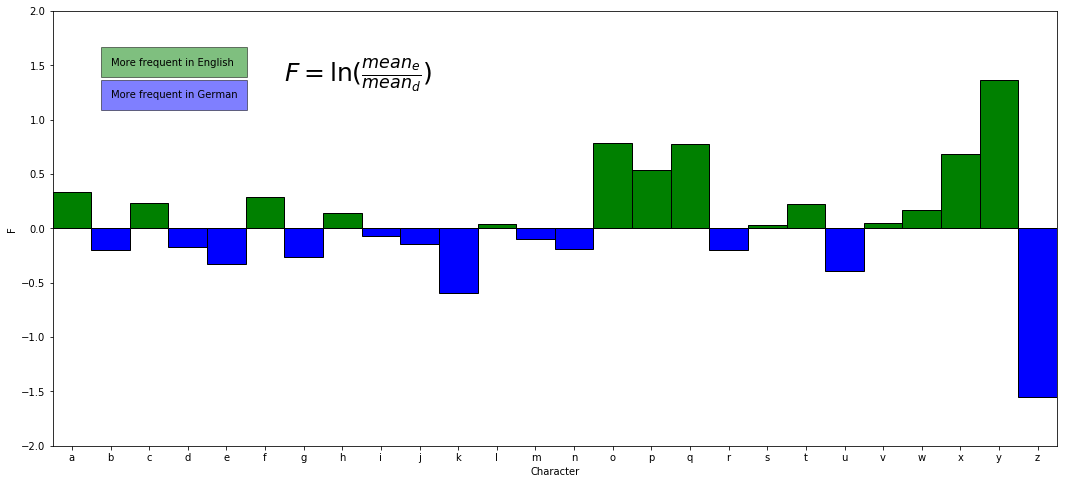

In [10]:
frequency_plot(mean_en, mean_de)

## Spracherkennung

In [11]:
def determine_language(mean_de, std_de, mean_en, std_en, texts):
    # Implementieren Sie eine Funktion zur Erkennung der Sprache
    lang = []
    for index_text in range(texts.shape[0]):
        # Get the text
        text = texts[index_text]

        # Check if some ASCII alphabet values are missing and need to be added
        for index_character, character in enumerate(string.ascii_lowercase):
            if character not in text:
                text += character

        # Get the frequency
        frequency = nltk.FreqDist(text)

        # Create a zero'd numpy array
        logarithms_german = np.zeros(shape = 26)
        logarithms_english = np.zeros(shape = 26)

        # Calculate all logaritmic values and add them to the array
        for index_character, character in enumerate(string.ascii_lowercase):
            i = index_character # Shorter variable name
            # Disclaimer: I had to ask Yanick Schraner on how to calculate the value for np.log
            logarithms_german[i] = np.log(scipy.stats.norm.pdf(frequency.freq(character), mean_de[i], std_de[i]))
            logarithms_english[i] = np.log(scipy.stats.norm.pdf(frequency.freq(character), mean_en[i], std_en[i]))

        # Get the sum of the arrays
        sum_german = np.sum(logarithms_german)
        sum_english = np.sum(logarithms_english)
                
        # Approach 1: Use a static value for p critical
        # Problem: Not flexibel enough because German and English can be different (and AND is not a good idea)
        '''limit_critical = 5
        if sum_german > sum_english and sum_german > limit_critical:
            lang.append('G')
        elif sum_english > limit_critical:
            lang.append('E')
        else:
            lang.append('X')'''
        
        # Approach 2: Check if both sum are larger than a minimum size + compare German/English afterwards
        # Problem: Some languages are still really really English-like, but not German-like (or vica versa)
        '''limit_critical = 10
        if sum_german >= limit_critical and sum_english >= limit_critical:
            if sum_german > sum_english:
                lang.append('G')
            else:
                lang.append('E')
        else:
            lang.append('X')'''
        
        # Approach 3: Back to square one: Use an OR and just find a value by trial and error. I am impressed it is so easy as described in the PDF...
        #print(i, sum_german, sum_english)
        limit_valid = 50 # Adapt value if required
        if(sum_german > limit_valid or sum_english > limit_valid):
            if sum_german > sum_english:
                lang.append('G')
            else:
                lang.append('E')
        else:
            lang.append('X')
        

    return lang

In [12]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [13]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])

In [14]:
lang = determine_language(mean_de, std_de, mean_en, std_en, people_test['text'])
cm = confusion_matrix(lang_true, lang)
print('Accuracy:', accuracy(cm))

Accuracy: 1.0


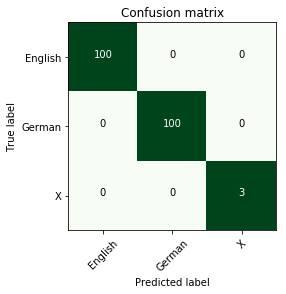

In [15]:
plot_confusion_matrix(cm, ['English', 'German', 'X'])